In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Constant import Constant
from Moment import Moment
from Team import Team
from Game import Game
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Circle, Rectangle, Arc

In [8]:
import constants_ui

In [5]:
import torch

In [4]:
game = Game('data/0021500001.json')
game.read_json()

loading  472


In [7]:
%store -r ds0

In [103]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

class BasketballAnimation():
    def __init__(self, mbd, x, id_team, id_player, t):
        self.fig = plt.figure(figsize=(8, 6))
        self.ax = plt.axes(xlim=(Constant.X_MIN, Constant.X_MAX-Constant.DIFF),
                           ylim=(Constant.Y_MIN, Constant.Y_MAX))
        self.x = x
        self.id_team = id_team
        self.id_player = id_player
        # self.ax.axis('off')
        self.ax.grid(True, 'both')
        n_players = x.shape[-2]
        
        self.clock_info = self.ax.annotate('', xy=[Constant.X_CENTER, Constant.Y_CENTER],
                                 color='black', horizontalalignment='center',
                                 verticalalignment='center')

        self.circle_texts = [self.ax.annotate('', xy=[0, 0], color='w',
                                   horizontalalignment='center',
                                   verticalalignment='center', fontweight='bold')
                       for player in range(n_players)]

        # Prepare table
        # sorted_players = sorted(start_moment.players, key=lambda player: player.team.id)
        team_ids = ds['id_team'][0, [1,-1]].tolist()
        
        # home_player = sorted_players[0]
        # guest_player = sorted_players[5]
        column_labels = [mbd.team_id2data[i]['abbreviation'] for i in team_ids]
        column_colours = [constants_ui.team_id2color[i] for i in team_ids]
        cell_colours = [column_colours for _ in range(5)]
        
        players_home = [f"{mbd.player_id2data[i]['firstname']} {mbd.player_id2data[i]['lastname']} "+
                        f"#{mbd.player_id2data[i]['jersey']} {mbd.player_id2data[i]['position']}" for i in ds['id_player'][0][1:6].tolist()]
        players_away = [f"{mbd.player_id2data[i]['firstname']} {mbd.player_id2data[i]['lastname']} "+
                        f"#{mbd.player_id2data[i]['jersey']} {mbd.player_id2data[i]['position']}" for i in ds['id_player'][0][6:11].tolist()]
        # players_home = [f"{mbd.player_id2data[i]['firstname']} {mbd.player_id2data[i]['lastname']} " for i in ds['id_player'][0][1:6].tolist()]
        # players_away = [f"{mbd.player_id2data[i]['firstname']} {mbd.player_id2data[i]['lastname']} " for i in ds['id_player'][0][6:11].tolist()]
        players_data = list(zip(players_home, players_away))
        table = plt.table(cellText=players_data,
                          colLabels=column_labels,
                          colColours=column_colours,
                          colWidths=[.5]*2,
                          loc='bottom',
                          cellColours=cell_colours,
                          fontsize=Constant.FONTSIZE,
                          cellLoc='center')
        table.scale(1, Constant.SCALE)
        for cell in table.get_celld().values():
            cell.set_text_props(c='white')

        self.circles = [plt.Circle((0, 0), Constant.PLAYER_CIRCLE_SIZE, color='r')
                          for player in range(n_players)]
        for circle in self.circles:
            self.ax.add_patch(circle)

        self.anim = animation.FuncAnimation(
                         self.fig, self.animation_step,
                         init_func=self.animation_init,
                         # fargs=(self.circles,),
                         frames=len(x), interval=20, blit=True,
                         repeat=True)
        img_court = plt.imread("court.png")
        plt.imshow(img_court, zorder=0, extent=[Constant.X_MIN, Constant.X_MAX - Constant.DIFF, Constant.Y_MAX, Constant.Y_MIN])
        
    def animation_init(self):
        return self.animation_step(0)
    
    def animation_step(self, timestep):
        for circle_i, circle in enumerate(self.circles):
            circle.center = tuple(self.x[timestep, circle_i, :2].numpy())
            
        id_team = self.id_team[timestep]
        id_player = self.id_player[timestep]
        for i_player, (circle, circle_text) in enumerate(zip(self.circles, self.circle_texts)):
            circle.set_color(constants_ui.team_id2color[id_team[i_player].item()])
            circle_text.set_position(circle.center)
            player_data = mbd.player_id2data[id_player[i_player].item()]
            if 'jersey' in player_data:
                circle_text.set_text(f"{player_data['jersey']}{player_data['position']}")
            
        return self.circles#+self.circle_texts
    
    def update_radius(self, i, circles, ball_circle, annotations, clock_info):
        moment = self.moments[i]
        for j, circle in enumerate(circles):
            circle.center = moment.players[j].x, moment.players[j].y
            annotations[j].set_position(circle.center)
            clock_test = 'Quarter {:d}\n {:02d}:{:02d}\n {:03.1f}'.format(
                         moment.quarter,
                         int(moment.game_clock) % 3600 // 60,
                         int(moment.game_clock) % 60,
                         moment.shot_clock)
            clock_info.set_text(clock_test)
        ball_circle.center = moment.ball.x, moment.ball.y
        ball_circle.radius = moment.ball.radius / Constant.NORMALIZATION_COEF
        return circles, ball_circle


In [104]:
ds = torch.load('data_processed/0021500001_00000.pth')
mbd = torch.load('data_processed/mbd')

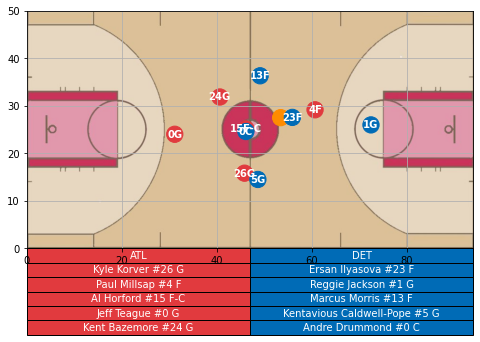

In [105]:
ba = BasketballAnimation(mbd, ds['x'], ds['id_team'], ds['id_player'], None)

In [106]:
! rm vid.gif

In [107]:
ba.anim.save('vid.gif', writer='imagemagick')

In [105]:
import constants_ui

In [96]:
import torch

In [ ]:

class Event:
    """A class for handling and showing events"""

    def __init__(self, event):
        moments = event['moments']
        self.moments = [Moment(moment) for moment in moments]
        home_players = event['home']['players']
        guest_players = event['visitor']['players']
        players = home_players + guest_players
        player_ids = [player['playerid'] for player in players]
        player_names = [" ".join([player['firstname'],
                        player['lastname']]) for player in players]
        player_jerseys = [player['jersey'] for player in players]
        values = list(zip(player_names, player_jerseys))
        # Example: 101108: ['Chris Paul', '3']
        self.player_ids_dict = dict(zip(player_ids, values))



In [ ]:
x = torch.randn(100, 11, 3)
t = torch.randn(100)
id_player = torch.randint(100, 11)
id_team = torch.randint(100, 11)

In [99]:
game.events[0].moments[0].players[0]

In [30]:
import pandas as pd
import numpy as np

In [76]:
%%time
df = pd.read_json('data/0021500025.json')

CPU times: user 1.31 s, sys: 508 ms, total: 1.82 s
Wall time: 1.92 s


In [77]:
%%time
df = pd.read_json('data/0021500027.json', lines=True, nrows=1)

CPU times: user 8.67 s, sys: 657 ms, total: 9.32 s
Wall time: 9.53 s


In [35]:
np.sum([len(df['events'][i]['moments']) for i in range(len(df['events']))])

240662

In [51]:
df['events'][0]['moments']

[[1,
  1446001336003,
  720.0,
  24.0,
  None,
  [[-1, -1, 47.31613, 28.93469, 4.15209],
   [1610612744, 101106, 49.3586, 27.59771, 0.0],
   [1610612744, 201939, 76.43181, 24.98459, 0.0],
   [1610612744, 202691, 49.44117, 16.99681, 0.0],
   [1610612744, 203110, 54.95641, 25.42404, 0.0],
   [1610612744, 203084, 48.81429, 36.02786, 0.0],
   [1610612740, 101126, 28.55486, 24.47234, 0.0],
   [1610612740, 2570, 54.83972, 25.12778, 0.0],
   [1610612740, 201967, 46.85451, 35.69175, 0.0],
   [1610612740, 201569, 45.17577, 16.98007, 0.0],
   [1610612740, 203076, 48.06968, 29.04586, 0.0]]],
 [1,
  1446001336043,
  720.0,
  24.0,
  None,
  [[-1, -1, 47.52618, 29.16356, 4.05133],
   [1610612744, 101106, 49.40069, 27.45404, 0.0],
   [1610612744, 201939, 76.46132, 24.96451, 0.0],
   [1610612744, 202691, 49.41942, 16.98294, 0.0],
   [1610612744, 203110, 55.01766, 25.48219, 0.0],
   [1610612744, 203084, 48.64789, 36.01908, 0.0],
   [1610612740, 101126, 28.50228, 24.47685, 0.0],
   [1610612740, 2570, 5